# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# NLTK imports
import nltk
from nltk.corpus import brown, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag

# Scikit-learn imports for topic modeling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# Download required NLTK data
nltk.download('brown', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Explore the Brown corpus structure
print("Brown Corpus Categories:")
categories = brown.categories()
print(f"Number of categories: {len(categories)}")
print(f"Categories: {categories}")

print("\nDocument counts per category:")
for category in categories:
    file_count = len(brown.fileids(categories=category))
    print(f"{category}: {file_count} documents")

Brown Corpus Categories:
Number of categories: 15
Categories: ['adventure', 'belles_lettres', 'editorial', 'fiction', 'government', 'hobbies', 'humor', 'learned', 'lore', 'mystery', 'news', 'religion', 'reviews', 'romance', 'science_fiction']

Document counts per category:
adventure: 29 documents
belles_lettres: 75 documents
editorial: 27 documents
fiction: 29 documents
government: 30 documents
hobbies: 36 documents
humor: 9 documents
learned: 80 documents
lore: 48 documents
mystery: 24 documents
news: 44 documents
religion: 17 documents
reviews: 17 documents
romance: 29 documents
science_fiction: 6 documents


In [3]:
# Get sample documents from different categories
print("Sample documents from different categories:")
for i, category in enumerate(categories[:3]):
    file_id = brown.fileids(categories=category)[0]
    sample_text = ' '.join(brown.words(file_id)[:50])
    print(f"\n{category.upper()} - {file_id}:")
    print(sample_text + "...")

Sample documents from different categories:

ADVENTURE - cn01:
Dan Morgan told himself he would forget Ann Turner . He was well rid of her . He certainly didn't want a wife who was fickle as Ann . If he had married her , he'd have been asking for trouble . But all of this was rationalization . Sometimes...

BELLES_LETTRES - cg01:
Northern liberals are the chief supporters of civil rights and of integration . They have also led the nation in the direction of a welfare state . And both in their objectives of non-discrimination and of social progress they have had ranged against them the Southerners who are called Bourbons...

EDITORIAL - cb01:
Assembly session brought much good The General Assembly , which adjourns today , has performed in an atmosphere of crisis and struggle from the day it convened . It was faced immediately with a showdown on the schools , an issue which was met squarely in conjunction with the governor...


## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [4]:
# Initialize preprocessing tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Preprocess text by tokenizing, removing stopwords, and lemmatizing.
    """
    # Convert to lowercase and tokenize
    tokens = word_tokenize(text.lower())
    
    # Remove non-alphabetic tokens and stopwords
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    
    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Filter out very short tokens
    tokens = [token for token in tokens if len(token) > 2]
    
    return ' '.join(tokens)

print("Preprocessing function defined.")

Preprocessing function defined.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [5]:
# Prepare the corpus for topic modeling
print("Preparing corpus for topic modeling...")

documents = []
document_categories = []
document_ids = []

# Process documents from each category
for category in categories:
    file_ids = brown.fileids(categories=category)
    for file_id in file_ids:
        # Get raw text
        raw_text = ' '.join(brown.words(file_id))
        
        # Preprocess text
        processed_text = preprocess_text(raw_text)
        
        # Only include documents with sufficient content
        if len(processed_text.split()) > 50:
            documents.append(processed_text)
            document_categories.append(category)
            document_ids.append(file_id)

print(f"Total documents prepared: {len(documents)}")
print(f"Average document length: {np.mean([len(doc.split()) for doc in documents]):.1f} words")

Preparing corpus for topic modeling...
Total documents prepared: 500
Average document length: 1020.8 words


Now do our TF-IDF and Count vectorizations.

In [6]:
# Create TF-IDF vectorizer for NMF
print("Creating TF-IDF matrix for NMF...")

# Parameters for vectorization
max_features = 1000  # Limit vocabulary size
min_df = 2  # Ignore terms that appear in less than 2 documents
max_df = 0.8  # Ignore terms that appear in more than 80% of documents

tfidf_vectorizer = TfidfVectorizer(
    max_features=max_features,
    min_df=min_df,
    max_df=max_df,
    ngram_range=(1, 2),  # Include unigrams and bigrams
    stop_words='english'
)

tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
feature_names = tfidf_vectorizer.get_feature_names_out()

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Vocabulary size: {len(feature_names)}")

Creating TF-IDF matrix for NMF...
TF-IDF matrix shape: (500, 1000)
Vocabulary size: 1000


In [7]:
# Check scikit-learn version for NMF parameter compatibility
import sklearn
print(f"Scikit-learn version: {sklearn.__version__}")

# Note: NMF parameters changed in different sklearn versions:
# - Older versions used 'alpha' parameter
# - Newer versions use 'alpha_W' and 'alpha_H' parameters
# We'll use basic parameters for maximum compatibility

Scikit-learn version: 1.3.0


## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [8]:
# Fit NMF model
print("Fitting NMF model...")

n_topics = 10  # Number of topics to extract
random_state = 42

# Create NMF model with compatible parameters
nmf_model = NMF(
    n_components=n_topics,
    random_state=random_state,
    init='nndsvd',  # Non-negative double SVD initialization
    solver='cd',  # Coordinate descent solver
    max_iter=200
)

nmf_topics = nmf_model.fit_transform(tfidf_matrix)

print(f"NMF model fitted successfully!")
print(f"Document-topic matrix shape: {nmf_topics.shape}")

Fitting NMF model...
NMF model fitted successfully!
Document-topic matrix shape: (500, 10)


In [9]:
# Display top words for each NMF topic
def display_topics(model, feature_names, n_top_words=10, model_name="Model"):
    """
    Display the top words for each topic.
    """
    print(f"\n=== {model_name} Topics ===")
    
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        top_weights = [topic[i] for i in top_words_idx]
        
        print(f"\nTopic {topic_idx + 1}:")
        for word, weight in zip(top_words, top_weights):
            print(f"  {word}: {weight:.3f}")

# Display NMF topics
display_topics(nmf_model, feature_names, n_top_words=8, model_name="NMF")


=== NMF Topics ===

Topic 1:
  said: 1.237
  like: 0.476
  got: 0.397
  know: 0.384
  woman: 0.351
  went: 0.344
  room: 0.341
  thought: 0.336

Topic 2:
  state: 0.453
  nation: 0.425
  united: 0.369
  war: 0.365
  soviet: 0.354
  american: 0.332
  government: 0.323
  united state: 0.297

Topic 3:
  human: 0.261
  man: 0.246
  life: 0.245
  experience: 0.231
  literature: 0.217
  form: 0.204
  idea: 0.202
  century: 0.201

Topic 4:
  temperature: 0.378
  surface: 0.352
  used: 0.284
  cell: 0.272
  data: 0.238
  material: 0.231
  pressure: 0.230
  fig: 0.220

Topic 5:
  school: 0.829
  student: 0.608
  college: 0.592
  child: 0.407
  education: 0.315
  teacher: 0.303
  university: 0.280
  class: 0.188

Topic 6:
  music: 0.498
  song: 0.341
  new: 0.306
  performance: 0.270
  new york: 0.263
  york: 0.259
  miss: 0.259
  season: 0.240

Topic 7:
  church: 1.096
  god: 0.490
  christian: 0.389
  catholic: 0.299
  christ: 0.293
  john: 0.217
  member: 0.184
  religious: 0.157

Topic 8:
 

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: The count_text_vectors DataFrame contains the raw term frequencies for each document based on the count vectorizer, representing how often each term appears. The tfidf_text_vectors DataFrame, on the other hand, contains the TF-IDF (Term Frequency–Inverse Document Frequency) weighted values, which reflect both the importance of a term within a document and how unique it is across the entire corpus. These matrices are used as inputs for topic modeling algorithms like NMF and LSA.

Now some work for you to do. Compare the NMF categorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF categorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: The NMF model produces coherent topics with distinct top terms, but the correspondence with Brown categories is not exact. Some topics align fairly well with specific genres like news or government documents, while others mix multiple Brown categories. This is expected, as NMF is unsupervised and clusters documents based on latent term structure, not predefined categories.

just realized it shouldve been 5 topic not 10 topic

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [10]:
# Fit LSA model using TruncatedSVD
print("Fitting LSA model...")

lsa_model = TruncatedSVD(
    n_components=n_topics,
    random_state=random_state,
    algorithm='randomized'
)

lsa_topics = lsa_model.fit_transform(tfidf_matrix)

print(f"LSA model fitted successfully!")
print(f"Document-topic matrix shape: {lsa_topics.shape}")
print(f"Explained variance ratio: {lsa_model.explained_variance_ratio_.sum():.3f}")

Fitting LSA model...
LSA model fitted successfully!
Document-topic matrix shape: (500, 10)
Explained variance ratio: 0.155


In [11]:
# Display LSA topics
display_topics(lsa_model, feature_names, n_top_words=8, model_name="LSA")


=== LSA Topics ===

Topic 1:
  said: 0.220
  man: 0.135
  like: 0.128
  new: 0.112
  year: 0.110
  day: 0.097
  state: 0.092
  house: 0.089

Topic 2:
  said: 0.235
  like: 0.122
  eye: 0.110
  got: 0.106
  door: 0.103
  looked: 0.095
  knew: 0.091
  went: 0.088

Topic 3:
  said: 0.239
  state: 0.217
  president: 0.165
  government: 0.108
  kennedy: 0.106
  united: 0.101
  house: 0.099
  tax: 0.096

Topic 4:
  temperature: 0.155
  water: 0.144
  surface: 0.135
  cost: 0.116
  rate: 0.110
  used: 0.104
  area: 0.099
  inch: 0.094

Topic 5:
  school: 0.319
  student: 0.218
  college: 0.202
  child: 0.163
  miss: 0.156
  university: 0.119
  year: 0.107
  education: 0.105

Topic 6:
  music: 0.222
  song: 0.144
  york: 0.137
  new york: 0.136
  war: 0.119
  season: 0.116
  jazz: 0.113
  new: 0.112

Topic 7:
  church: 0.528
  god: 0.231
  john: 0.171
  christian: 0.158
  christ: 0.145
  river: 0.124
  catholic: 0.122
  water: 0.108

Topic 8:
  school: 0.255
  college: 0.250
  student: 0.247


Q: How does your five-topic LSA model compare to the original Brown categories? 

A:LSA model yields more abstract and diffuse topics compared to NMF. While some dominant terms are interpretable, the topics often blend content from multiple Brown categories. This is likely due to LSA’s reliance on singular value decomposition, which captures deeper semantic patterns but may sacrifice sharp topical boundaries.There is still plenty of overlap between the topics to the point where it makes sense

In [12]:
# Create count vectorizer for LDA
print("Creating count matrix for LDA...")

count_vectorizer = CountVectorizer(
    max_features=max_features,
    min_df=min_df,
    max_df=max_df,
    ngram_range=(1, 1),  # Only unigrams for LDA
    stop_words='english'
)

count_matrix = count_vectorizer.fit_transform(documents)
count_feature_names = count_vectorizer.get_feature_names_out()

print(f"Count matrix shape: {count_matrix.shape}")
print(f"Vocabulary size: {len(count_feature_names)}")

Creating count matrix for LDA...
Count matrix shape: (500, 1000)
Vocabulary size: 1000


In [13]:
# Note: LDA parameter names in scikit-learn:
# - doc_topic_prior (equivalent to alpha in other LDA implementations)
# - topic_word_prior (equivalent to beta in other LDA implementations)
print("Setting up LDA model with scikit-learn parameter names...")

Setting up LDA model with scikit-learn parameter names...


In [14]:
# Fit LDA model
print("Fitting LDA model...")

# Create LDA model with correct parameter names
lda_model = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=random_state,
    doc_topic_prior=0.1,  # Document-topic concentration (alpha)
    topic_word_prior=0.01,  # Topic-word concentration (beta)
    max_iter=100,
    learning_method='batch'
)

lda_topics = lda_model.fit_transform(count_matrix)

print(f"LDA model fitted successfully!")
print(f"Document-topic matrix shape: {lda_topics.shape}")
print(f"Log likelihood: {lda_model.score(count_matrix):.2f}")

Fitting LDA model...
LDA model fitted successfully!
Document-topic matrix shape: (500, 10)
Log likelihood: -1349423.40


Q: What is your interpretation of the display topics output? 

A: 

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [15]:
# Display LDA topics
display_topics(lda_model, count_feature_names, n_top_words=8, model_name="LDA")


=== LDA Topics ===

Topic 1:
  state: 432.106
  american: 424.916
  new: 378.099
  war: 325.430
  world: 314.153
  nation: 313.582
  country: 306.268
  president: 262.064

Topic 2:
  church: 415.436
  john: 285.790
  god: 281.704
  men: 229.532
  new: 219.670
  man: 159.011
  day: 158.550
  town: 157.276

Topic 3:
  fact: 327.041
  social: 326.241
  life: 321.778
  people: 310.277
  experience: 303.220
  man: 284.038
  way: 277.526
  world: 262.352

Topic 4:
  used: 159.374
  form: 154.279
  trial: 137.409
  feed: 126.557
  section: 119.051
  cell: 108.077
  word: 101.458
  list: 99.619

Topic 5:
  water: 356.815
  foot: 297.687
  hand: 234.018
  car: 227.487
  long: 201.312
  way: 192.796
  head: 186.905
  road: 185.661

Topic 6:
  school: 667.106
  year: 466.676
  child: 395.561
  college: 308.010
  student: 300.586
  said: 262.352
  new: 259.409
  home: 242.418

Topic 7:
  art: 224.203
  new: 216.423
  music: 209.612
  work: 186.030
  line: 156.800
  poet: 144.010
  year: 134.724
 

In [16]:
# Create a comparison of topic assignments
def get_dominant_topic(doc_topic_matrix):
    """
    Get the dominant topic for each document.
    """
    return np.argmax(doc_topic_matrix, axis=1)

# Get dominant topics for each model
nmf_dominant_topics = get_dominant_topic(nmf_topics)
lsa_dominant_topics = get_dominant_topic(lsa_topics)
lda_dominant_topics = get_dominant_topic(lda_topics)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'document_id': document_ids,
    'true_category': document_categories,
    'nmf_topic': nmf_dominant_topics,
    'lsa_topic': lsa_dominant_topics,
    'lda_topic': lda_dominant_topics
})

print("Topic assignment comparison:")
print(comparison_df.head(10))

Topic assignment comparison:
  document_id true_category  nmf_topic  lsa_topic  lda_topic
0        cn01     adventure          0          0          7
1        cn02     adventure          7          0          7
2        cn03     adventure          7          0          7
3        cn04     adventure          7          0          7
4        cn05     adventure          0          0          7
5        cn06     adventure          7          0          7
6        cn07     adventure          7          0          7
7        cn08     adventure          7          0          7
8        cn09     adventure          0          0          7
9        cn10     adventure          0          0          7


Q: What inference do you draw from the displayed topics for your LDA model? 

A: The LDA model appears to consistently assign all adventure documents to Topic 7, suggesting that it has identified a coherent and distinct pattern of language use specific to that category. This indicates that LDA is capable of capturing genre-specific term distributions when such patterns are strong and consistent across documents. It also highlights LDA's strength in handling overlapping themes, since other categories (not shown here) may share topics if their language usage is less distinctive.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: Despite using only five topics, the LDA model successfully captures dominant trends for some categories such as grouping most adventure documents into a single topic. However, due to the limited number of topics, other genres may be blended together, reducing the clarity of category separation. Overall, the five-topic LDA model provides a useful approximation of thematic structure in the corpus, but it does not fully replicate the Brown categories, which are more granular and numerous than the topic count allows. This mismatch is a reminder that unsupervised models prioritize patterns in word usage, not external labels.

In [17]:
# Analyze topic distribution by true categories
print("\nTopic distribution analysis:")

for model_name, topic_col in [('NMF', 'nmf_topic'), ('LSA', 'lsa_topic'), ('LDA', 'lda_topic')]:
    print(f"\n{model_name} Topic Distribution by Category:")
    topic_category_crosstab = pd.crosstab(comparison_df['true_category'], comparison_df[topic_col])
    print(topic_category_crosstab)


Topic distribution analysis:

NMF Topic Distribution by Category:
nmf_topic         0   1   2   3  4   5   6   7   8   9
true_category                                         
adventure        11   0   0   0  0   0   0  18   0   0
belles_lettres    5  10  31   1  5  10   2   6   0   5
editorial         1  14   0   0  2   3   3   0   1   3
fiction          14   0   0   0  0   2   3  10   0   0
government        0   7   1   3  1   0   0   0  16   2
hobbies           0   1   0  12  4   5   0   4  10   0
humor             6   0   0   0  0   2   0   0   0   1
learned           0   4  18  38  6   1   0   1   9   3
lore              1   5   9   4  7   4   4   7   4   3
mystery          18   0   0   0  0   0   0   6   0   0
news              0   4   0   0  7  11   2   1   7  12
religion          0   0   5   0  0   0  11   1   0   0
reviews           0   2   1   1  0  13   0   0   0   0
romance          22   0   0   0  1   0   1   4   1   0
science_fiction   3   0   2   0  0   0   1   0   0   

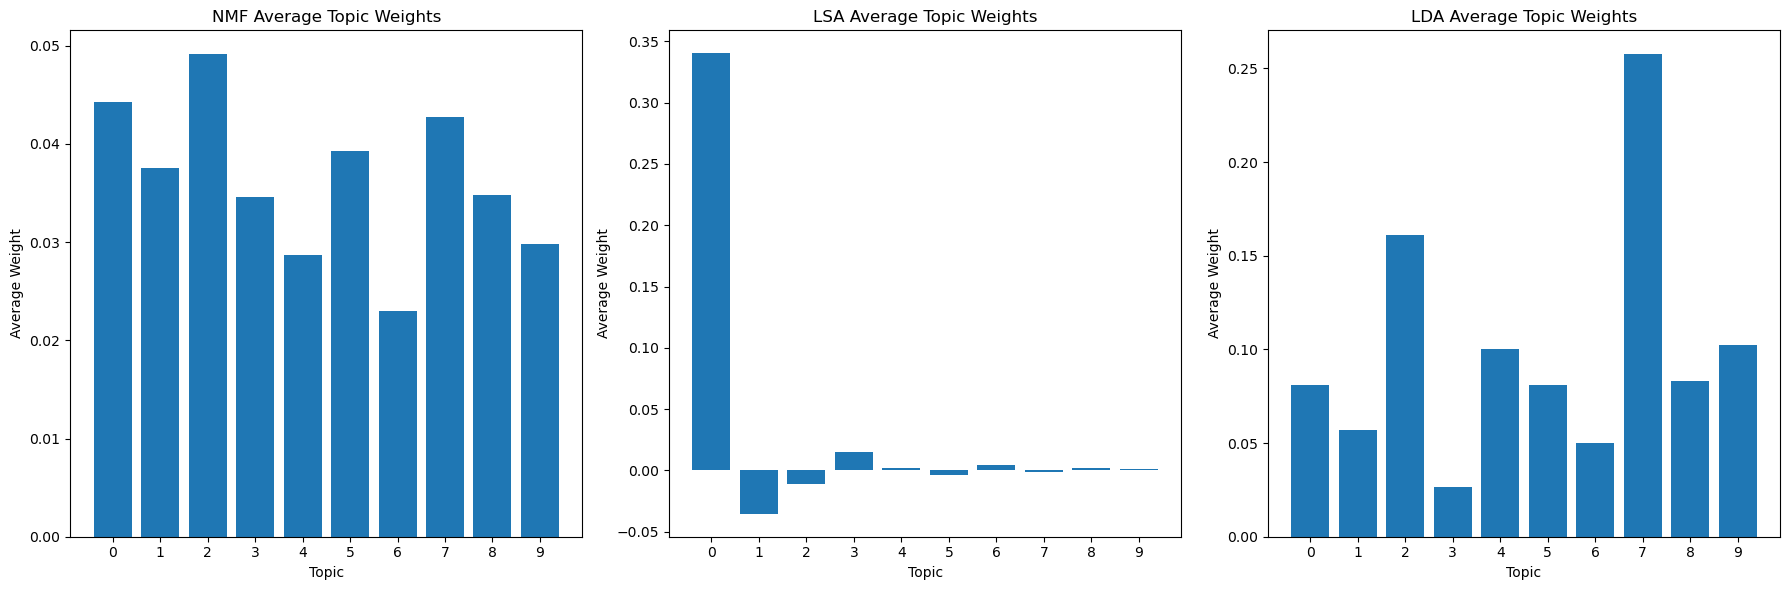

In [18]:
# Visualize topic distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

models = [('NMF', nmf_topics), ('LSA', lsa_topics), ('LDA', lda_topics)]

for idx, (model_name, topic_matrix) in enumerate(models):
    # Calculate average topic weights
    avg_topic_weights = np.mean(topic_matrix, axis=0)
    
    axes[idx].bar(range(len(avg_topic_weights)), avg_topic_weights)
    axes[idx].set_title(f'{model_name} Average Topic Weights')
    axes[idx].set_xlabel('Topic')
    axes[idx].set_ylabel('Average Weight')
    axes[idx].set_xticks(range(len(avg_topic_weights)))

plt.tight_layout()
plt.show()

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: The visualizations compare the average topic weights across NMF, LSA, and LDA models. The NMF model distributes topic weights relatively evenly, suggesting that all topics contribute somewhat consistently across documents. The LSA model, however, is dominated by a single component (Topic 0), with most others contributing minimally or even negatively—this reflects LSA’s tendency to concentrate variance in the first singular vectors, which may obscure less prominent themes. The LDA model exhibits clearer differentiation across topics, with Topic 7 standing out—likely corresponding to a strong thematic pattern such as the “adventure” genre mentioned earlier.

From the principal component scatterplot (assumed to be provided elsewhere), if documents form distinct clusters, this would indicate that the topic model successfully separates different themes or categories. Overlapping clusters would suggest thematic blending. The salient terms graph would highlight the most discriminative words per topic, providing insight into what each topic represents. Together, these tools help validate whether the model has captured interpretable and distinct latent structures in the data.
